# vine copula (vinecop) dataclasses and factory methods.

- Fitting

> obs -> edge -> tree -> bcp -> (next lv) obs

The function `tvc.vinecop.vcp_from_obs` takes multivariate copula observations (of shape $(n,D)$ and values inside $(0,1)$). By default at each level, it proposes potential edges between (pseudo)observations under proximity conditions, calculates corresponding bivariate dependency metrics to determine bicops-to-fit using modified Kruskal's maximum spanning tree (MST, Dissmann 2013), then fit bicops and calculates pseudo-obs for the next level using their `hfunc`.

This function can make `DataVineCop` following c/d/r-vine restrictions using Dissmann algo, and can use existing structure matrix to make `DataVineCop`.

This function can prioritize vertices inside `tpl_first` such that the fitted vine can be used to conduct **conditional simulation**.

- Simulation (inverse Rosenblatt transform)

The `tpl_sim` attribute inside a `DataVineCop` object shows sequentially (from right to left, from shallowest to deepest) `D` pseudo-observation (on `D` levels) as source vertices to walk `D` paths until their corresponding `D` target vertices on the top level. Along each path, iteratively we do `hinv` from lower vertex to upper vertex, but may (recursively) request `hfunc` if one upper vertex is not available.

With `tpl_first` given during fitting, the fitted `DataVineCop` object allows for **conditional simulation**, where `dct_first` can be specified for `.sim()`.


In [3]:
import sys
import matplotlib.pyplot as plt
import torch

# * add proj root folder into path
sys.path.append("..")
import torchvinecopulib as tvc

print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_DIM = 7
num_sim = 10000
seed = 0
for _ in tvc.vinecop.__all__:
    print(f"\n{_}")
    print(tvc.vinecop.__getattribute__(_).__doc__)
print(f"\nbidep func avail: {tvc.util.ENUM_FUNC_BIDEP._member_names_}")

cuda (GPU) avail? True


DataVineCop
Dataclass for a vine copula model

vcp_from_json
load a DataVineCop from a json file

    :param f_path: path to the json file, defaults to Path("./vcp.json")
    :type f_path: Path, optional
    :return: a DataVineCop object
    :rtype: DataVineCop
    

vcp_from_obs
Construct a vine copula model from multivariate observations,
    with structure prescribed by either Dissmann's (MST per level) method or a given matrix.
    May prioritize some vertices to be first (shallower) in the quantile-regression/conditional-simulation workflow.

    :param obs_mvcp: multivariate observations, of shape (num_obs, num_dim)
    :type obs_mvcp: torch.Tensor
    :param is_Dissmann: whether to use Dissmann's method or follow a given matrix,
        defaults to True; Dissmann, J., Brechmann, E. C., Czado, C., & Kurowicka, D. (2013).
        Selecting and estimating regular vine copulae and application to financial returns.
        Computational Statistics & Data Anal

In [33]:
V_mvcp = torch.hstack(
    (
        tvc.bicop.BB1.sim(par=(0.1, 1.1), num_sim=10000, rot=0),
        tvc.bicop.BB6.sim(par=(0.1, 1.1), num_sim=10000, rot=90, seed=1),
    )
)
idx = torch.randperm(V_mvcp.shape[0])
V_mvcp[idx[:500], 0] = torch.nan
V_mvcp[idx[500:1000], 1] = torch.nan
V_mvcp[~V_mvcp.isnan().any(axis=1)]
# tvc.util.kendalltau(*V_mvcp[:,:2].T)
# V_mvcp[~V_mvcp.isnan().any(axis=1)]
# tvc.vinecop.vcp_from_obs(V_mvcp)

torch.Size([9000, 4])

In [ ]:
# simulate multivariate copula data from bicop
mdl_vcp = tvc.vinecop.vcp_from_sim(num_dim=NUM_DIM, seed=seed)
V_mvcp = mdl_vcp.sim(num_sim=num_sim, device=DEVICE, is_sobol=True)
# visualize first two dim
plt.scatter(*V_mvcp[:, [0, 1]].T.cpu(), s=0.3, alpha=0.8)
plt.grid()

NotImplementedError: 

In [ ]:
V_mvcp

## factory function


In [3]:
# make a DataVineCop object (from fitting the vinecop obs)
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp, tpl_fam=("Clayton",))
print(mdl_vcp)

{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 10_000,
 'num_par': 18,
 'negloglik': -17233.7431,
 'aic': -34431.4862,
 'bic': -34301.7001,
 'matrix': '[[ 3  6  4  5  2  1  0]'
           ' [-1  6  0  2  1  5  4]'
           ' [-1 -1  0  4  5  2  1]'
           ' [-1 -1 -1  2  4  5  1]'
           ' [-1 -1 -1 -1  1  4  5]'
           ' [-1 -1 -1 -1 -1  4  5]'
           ' [-1 -1 -1 -1 -1 -1  5]]',
 'tpl_sim': (3, 6, 0, 2, 1, 4, 5)}


## dataclass: "draw_lv"


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 0, BiDep Metric chatterjee_xi'}>,
 <networkx.classes.graph.Graph at 0x2191bd9e800>)

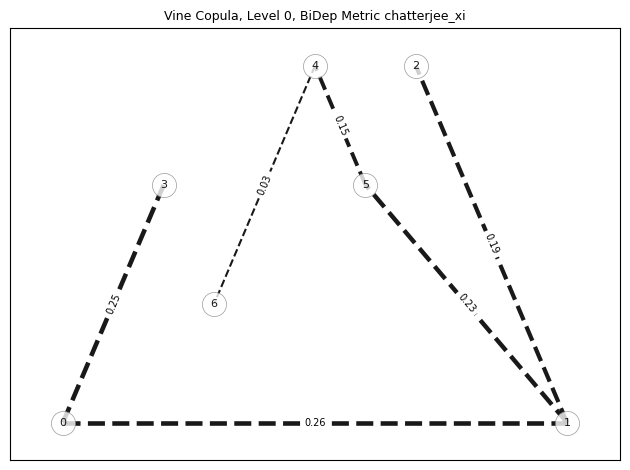

In [4]:
# for a certain level, draw the MST (of bcp) or the link between pseudo-obs
mdl_vcp.draw_lv(lv=0)

## dataclass: "cdf", "l_pdf"


In [5]:
for _ in ("cdf", "l_pdf"):
    print(f"{_}\t{mdl_vcp.__getattribute__(_)(V_mvcp)}")

cdf	tensor([[0.0003],
        [0.0349],
        [0.0000],
        ...,
        [0.0026],
        [0.0055],
        [0.0001]], device='cuda:0')
l_pdf	tensor([[-0.3009],
        [ 0.8663],
        [10.2639],
        ...,
        [ 2.4434],
        [-0.0810],
        [ 1.4961]], device='cuda:0', dtype=torch.float64)


## IO


In [6]:
import os

file = mdl_vcp.vcp_to_json()
print(file)
print(f"json IO? {mdl_vcp == tvc.vinecop.vcp_from_json(file)}")
os.remove(file)
file = mdl_vcp.vcp_to_pth()
print(file)
print(f"pth IO? {mdl_vcp == tvc.vinecop.vcp_from_pth(file)}")
os.remove(file)

vcp.json
json IO? True
vcp.pth
pth IO? True


c:\Users\tycheng\OneDrive - National University of Singapore\torchvinecopulib\examples\..\torchvinecopulib\vinecop\_factory_vcp.py:562: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

## draw_dag and cond sim


{'mtd_bidep': 'chatterjee_xi',
 'num_dim': 7,
 'num_obs': 10_000,
 'num_par': 19,
 'negloglik': -18237.2197,
 'aic': -36436.4394,
 'bic': -36299.4429,
 'matrix': '[[ 5  2  3  4  0  6  1]'
           ' [-1  2  3  4  0  6  1]'
           ' [-1 -1  3  4  0  6  1]'
           ' [-1 -1 -1  4  0  6  1]'
           ' [-1 -1 -1 -1  0  6  1]'
           ' [-1 -1 -1 -1 -1  6  1]'
           ' [-1 -1 -1 -1 -1 -1  1]]',
 'tpl_sim': (5, 2, 3, 4, 0, 6, 1)}


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Obs and BiCop'}>,
 <networkx.classes.digraph.DiGraph at 0x2191f7c99f0>)

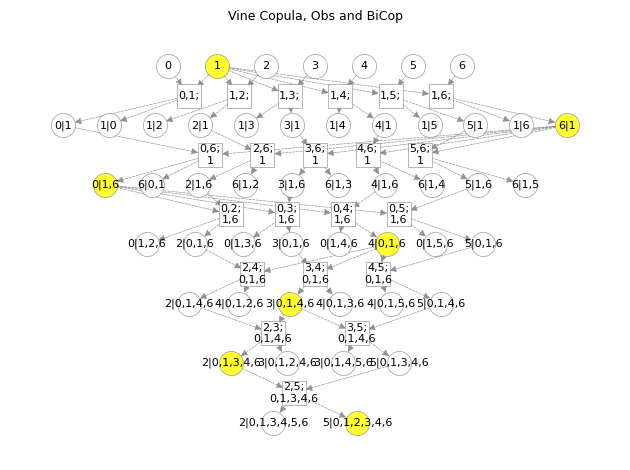

In [7]:
# give tpl_first to prioritize, show the default sim workflow (source vertices highlighted)
tpl_first = (1, NUM_DIM - 1)
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp, mtd_vine="cvine", tpl_first=tpl_first)
print(mdl_vcp)
mdl_vcp.draw_dag()

In [8]:
# by default, a full simulation
mdl_vcp.sim(num_sim=10000, device=DEVICE, is_sobol=True)

tensor([[4.2890e-01, 4.7511e-01, 2.3346e-01,  ..., 2.9589e-01, 3.9412e-01,
         5.8717e-01],
        [8.2096e-01, 7.8335e-01, 9.2937e-01,  ..., 7.3067e-01, 3.6247e-01,
         3.6947e-01],
        [2.1520e-04, 6.4966e-01, 9.2798e-01,  ..., 1.8056e-02, 7.4903e-01,
         9.7864e-01],
        ...,
        [6.9555e-01, 7.2514e-01, 6.6961e-01,  ..., 3.1397e-01, 3.4194e-01,
         4.6406e-01],
        [4.8723e-01, 8.4172e-01, 9.0861e-01,  ..., 5.2594e-01, 2.9830e-01,
         8.0541e-01],
        [7.7314e-01, 3.9969e-01, 1.1679e-01,  ..., 6.4464e-01, 3.1778e-01,
         7.1839e-03]], device='cuda:0', dtype=torch.float64)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Obs and BiCop'}>,
 <networkx.classes.digraph.DiGraph at 0x21b0479bb20>)

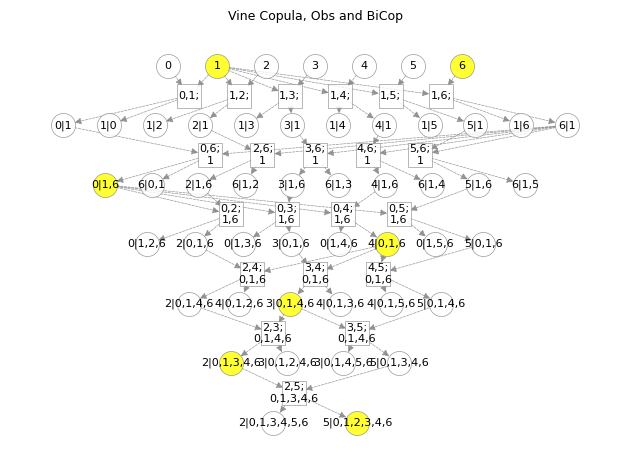

In [9]:
# show the sim workflow with tpl_first taken as simulated (source vertices highlighted), a cond sim
tpl_first_vs = tuple([(_, frozenset()) for _ in tpl_first])
mdl_vcp.draw_dag(tpl_first_vs=tpl_first_vs)

In [10]:
# prepare dct_first for a cond sim
num_sim = 10000
lst_obs = [0.7, 0.3]
dct_first_vs = {
    (idx, frozenset()): torch.ones(size=(num_sim, 1), device=DEVICE) * lst_obs[i]
    for i, idx in enumerate(tpl_first)
}
for k, v in dct_first_vs.items():
    print(k, v)

(1, frozenset()) tensor([[0.7000],
        [0.7000],
        [0.7000],
        ...,
        [0.7000],
        [0.7000],
        [0.7000]], device='cuda:0')
(6, frozenset()) tensor([[0.3000],
        [0.3000],
        [0.3000],
        ...,
        [0.3000],
        [0.3000],
        [0.3000]], device='cuda:0')


In [11]:
# NOTE cond sim: corresponding columns are preserved.
mdl_vcp.sim(
    num_sim=10000,
    dct_first_vs=dct_first_vs,
    device=DEVICE,
    is_sobol=True,
)

tensor([[0.6186, 0.7000, 0.5064,  ..., 0.5729, 0.5975, 0.3000],
        [0.6847, 0.7000, 0.8409,  ..., 0.4479, 0.0114, 0.3000],
        [0.8807, 0.7000, 0.1740,  ..., 0.9366, 0.1774, 0.3000],
        ...,
        [0.9439, 0.7000, 0.1154,  ..., 0.8469, 0.4660, 0.3000],
        [0.6519, 0.7000, 0.7405,  ..., 0.8863, 0.0424, 0.3000],
        [0.5804, 0.7000, 0.4166,  ..., 0.1348, 0.7727, 0.3000]],
       device='cuda:0', dtype=torch.float64)

## timeit


In [12]:
import pyvinecopulib as pvc

print(f"{tvc.__version__=}\n{pvc.__version__=}")

ctrls = pvc.FitControlsVinecop(
    family_set=[
        pvc.BicopFamily.clayton,
        pvc.BicopFamily.gumbel,
        pvc.BicopFamily.frank,
        pvc.BicopFamily.joe,
        pvc.BicopFamily.gaussian,
        pvc.BicopFamily.indep,
    ],
    parametric_method="itau",
    tree_criterion="tau",
    selection_criterion="aic",
)
lst_num_dim = [20, 40, 60, 80, 100]
for num_dim in lst_num_dim:
    num_sim = int(1000 * num_dim)
    print(f"\n{num_dim=}, {num_sim=}")
    # * same mvcop data to fit
    V_mvcp = tvc.vinecop.vcp_from_sim(num_dim=num_dim, seed=seed).sim(
        num_sim=5000, device=DEVICE
    )
    mdl_vcp = tvc.vinecop.vcp_from_obs(
        V_mvcp,
        mtd_fit="itau",
        mtd_bidep="kendall_tau",
        mtd_sel="aic",
        tpl_fam=("Clayton", "Gumbel", "Frank", "Joe", "Gaussian", "Independent"),
    )
    mdl_vcp_pvc = pvc.Vinecop(data=V_mvcp.cpu(), controls=ctrls)
    %timeit mdl_vcp.sim(num_sim=num_sim, device=DEVICE, dtype=torch.float64)
    %timeit mdl_vcp_pvc.simulate(n=num_sim, num_threads=12)

tvc.__version__='2024.9.0'
pvc.__version__='dev'

num_dim=20, num_sim=20000
541 ms ± 51.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
386 ms ± 4.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=40, num_sim=40000
1.88 s ± 38.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.88 s ± 73.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=60, num_sim=60000
3.71 s ± 17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.2 s ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=80, num_sim=80000
6.61 s ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
25.5 s ± 96.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=100, num_sim=100000
10.6 s ± 31.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
49.7 s ± 88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
